# Compare IBM's influence on individuals inside/outside IBM
Author: Daheng Wang  
Last modified: 2017-06-16

# Roadmap
1. Check the distribution of user_popularity levels of M1 IBM users
2. Check the distribution of followers_engagement levels of M1 IBM users
3. Simple influence by different (user_popularity, followers_engagement) combinations
4. Compound inlfuence by different (user_popularity, followers_engagement) combinations

# Steps

In [1]:
"""
Initialization
"""

'''
Data analysis modules: pandas, matplotlib, numpy, and etc.
'''
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # render double resolution plot output for Retina screens 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

'''
Standard modules, MongoDB modules
'''
import os, sys, json, datetime, pickle, multiprocessing, logging
from pprint import pprint

import pymongo
from pymongo import IndexModel, ASCENDING, DESCENDING

'''
Custom tool modules
'''
import mongodb  # module for setting up connection with (local) MongoDB database
import multiprocessing_workers  # module for splitting workloads between processes
import utilities  # module for various custom utility functions
from config import * # import all global configuration variables

'''
Misc
'''
NB_NAME = '20170615-compare_influence_inside_outside_2'

## EDA

In [2]:
'''
Load pickle data
'''
df = pd.read_pickle(IBM_INFLUENCE_PKL)

In [3]:
'''
Remove rows with NaN of fo_2
'''
df = df.dropna(subset=['fo_2'], how='any')

In [4]:
'''
Clean rows with native_n < all_n
'''
df = df.drop(df['native_n'] < df['all_n'])

In [5]:
'''
Clean other NaNs
'''
df = df.fillna(0)

In [6]:
df.shape

(3708, 11)

In [7]:
'''
Compute nubmer of non-IBM followers
'''
df = df.assign(fo_nonibm = df['fo_2'] - df['fo_ibm'])

In [8]:
df.describe(np.arange(0.1, 1, 0.1))

,uid,fo,all_n,all_srt,ibm_n,ibm_srt,nonibm_n,nonibm_srt,fo_2,fo_ibm,native_n,fo_nonibm
count,3.708000e+03,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000
mean,5.060382e+16,2086.938781,7.495955,35.831446,3.880529,11.131607,6.029935,24.699838,2103.889428,194.117584,19.926645,1909.771845
std,1.919076e+17,10348.294746,24.609970,359.441014,17.151148,114.842189,22.060280,251.072907,10405.718706,640.664591,56.686660,9915.959737
min,1.142600e+04,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,1.000000
10%,1.842220e+07,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,71.000000,8.000000,1.000000,50.000000
20%,3.938379e+07,127.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,135.000000,19.000000,2.000000,95.000000
30.0%,9.229542e+07,196.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,206.100000,33.000000,3.000000,150.000000
40%,2.118461e+08,281.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,290.000000,49.000000,4.000000,220.000000
50%,3.700978e+08,403.000000,2.000000,4.000000,1.000000,1.000000,1.000000,2.000000,415.500000,69.000000,5.000000,317.000000
60%,5.688451e+08,590.200000,3.000000,5.000000,1.000000,2.000000,2.000000,3.000000,609.200000,96.000000,8.000000,489.000000


In [9]:
'''
Separate influence on inside/outside users
'''
df_in = df[df['ibm_n'] > 0]
df_out = df[df['nonibm_n'] > 0]

In [10]:
df_out.describe()

,uid,fo,all_n,all_srt,ibm_n,ibm_srt,nonibm_n,nonibm_srt,fo_2,fo_ibm,native_n,fo_nonibm
count,3.174000e+03,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000
mean,5.426757e+16,2347.766541,8.539698,41.583806,4.316005,12.728418,7.044423,28.855388,2364.980466,209.311279,22.462823,2155.669187
std,1.983035e+17,11157.252926,26.456253,388.215307,18.500603,124.058004,23.694071,271.157832,11218.891164,689.851665,60.838627,10691.471972
min,1.142600e+04,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000
25%,5.679811e+07,165.250000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,174.000000,25.000000,3.000000,131.000000
50%,3.696389e+08,438.000000,2.000000,4.000000,1.000000,1.000000,2.000000,3.000000,451.000000,70.000000,6.000000,348.500000
75%,2.242133e+09,1283.750000,6.000000,13.000000,3.000000,4.000000,4.000000,8.000000,1314.750000,172.000000,20.000000,1107.000000
max,8.623589e+17,360556.000000,428.000000,14497.000000,333.000000,4877.000000,426.000000,9620.000000,362337.000000,16223.000000,1330.000000,346114.000000


In [11]:
'''
Compute simple influence on all/inside/outside users
'''
# simple influence to all users
all_norm_s = df['fo_2'] * df['native_n']
all_simple_inf = df['all_srt'] / all_norm_s
df = df.assign(all_simple_inf=all_simple_inf)

# simple influence to IBM users (inside)
in_norm_s = df_in['fo_ibm'] * df_in['native_n']
in_norm_s = in_norm_s.replace(to_replace=0, value=1) # clean 0 values since its denominator
in_simple_inf = df_in['ibm_srt'] / in_norm_s
df_in = df_in.assign(in_simple_inf=in_simple_inf)

# simple influence to non-IBM users (outside)
out_norm_s = df_out['fo_nonibm'] * df_out['native_n']
out_simple_inf = df_out['nonibm_srt'] / out_norm_s
df_out = df_out.assign(out_simple_inf=out_simple_inf)

'''
Compute compound influence on all/inside/outside users
'''
# compound influence to all users
all_arc = df['all_srt'] / df['native_n']
all_compound_inf = all_arc * np.log(df['fo_2'])
df = df.assign(all_compound_inf=all_compound_inf)

# compound influence to IBM users (inside)
ibm_arc = df_in['ibm_srt'] / df_in['native_n']
cleaned_ibm_fo = df_in['fo_ibm'].replace(to_replace=0, value=1) # clean 0 values since its denominator
in_compound_inf = ibm_arc * np.log(cleaned_ibm_fo)
df_in = df_in.assign(in_compound_inf=in_compound_inf)

# compound influence to non-IBM users (outside)
nonibm_arc = df_out['nonibm_srt'] / df_out['native_n']
out_compound_inf = nonibm_arc * np.log(df_out['fo_nonibm'])
df_out = df_out.assign(out_compound_inf=out_compound_inf)

In [12]:
df

,uid,fo,all_n,all_srt,ibm_n,ibm_srt,nonibm_n,nonibm_srt,fo_2,fo_ibm,native_n,fo_nonibm,all_simple_inf,all_compound_inf
2,1125997147,268,1,1,0.0,0.0,1.0,1.0,266.0,54.0,2,212.0,0.001880,2.791748
3,3180673488,193,1,1,0.0,0.0,1.0,1.0,207.0,95.0,5,112.0,0.000966,1.066544
4,145215551,4090,1,9,0.0,0.0,1.0,9.0,4133.0,17.0,2,4116.0,0.001089,37.470415
5,252689496,780,1,3,1.0,3.0,0.0,0.0,787.0,43.0,2,744.0,0.001906,10.002342
6,250787549,97,1,1,0.0,0.0,1.0,1.0,99.0,18.0,1,81.0,0.010101,4.595120
7,74639968,7738,1,2,0.0,0.0,1.0,2.0,7730.0,50.0,1,7680.0,0.000259,17.905728
9,21352000,104,1,1,0.0,0.0,1.0,1.0,114.0,22.0,1,92.0,0.008772,4.736198
10,44953327,105,1,1,1.0,1.0,0.0,0.0,101.0,14.0,1,87.0,0.009901,4.615121
11,475006262,370,1,1,0.0,0.0,1.0,1.0,382.0,3.0,8,379.0,0.000327,0.743178
12,19198185,239,1,1,1.0,1.0,0.0,0.0,239.0,8.0,1,231.0,0.004184,5.476464


## Check the distribution of user_popularity levels of M1 IBM users
The popularity level of a user is represented by his followers_count.

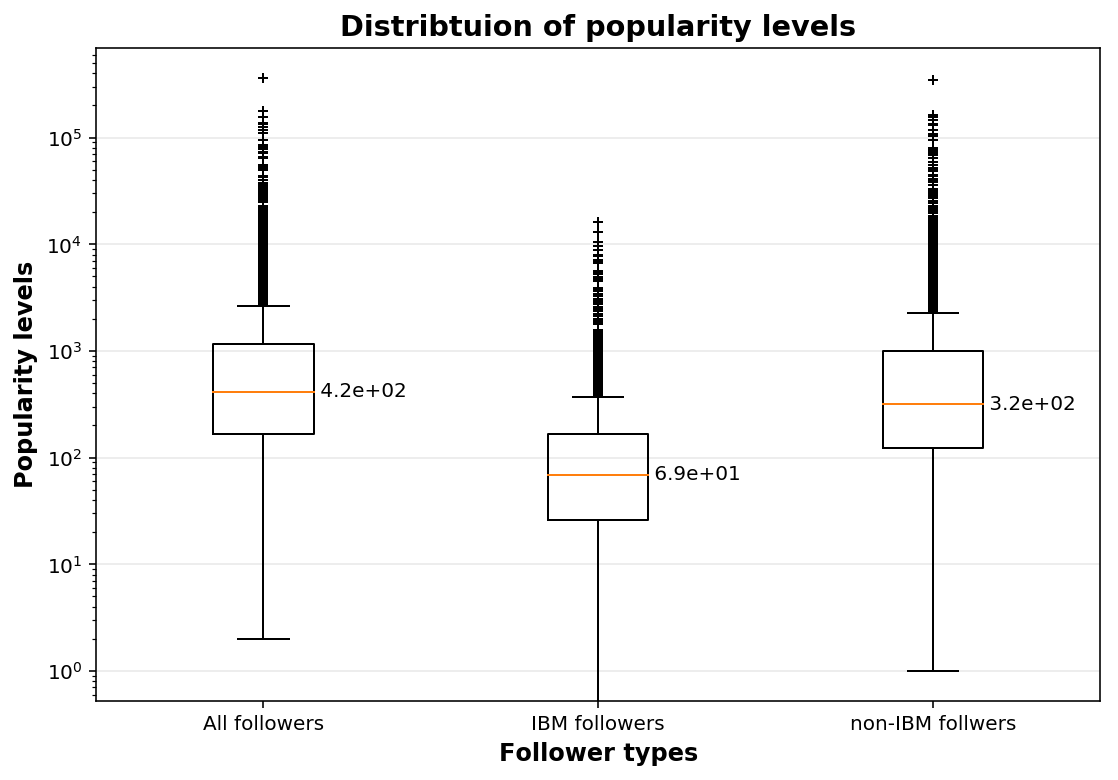

In [13]:
"""
Boxplot of total/IBM/non-IBM followers
"""
m1_ibm_popularity_levels_fig = os.path.join(FIG_DIR, 'm1_ibm_popularity_levels.png')
if 1 == 1:
    '''
    Prepare data
    '''
    followers_all = df['fo_2']
    followers_ibm = df['fo_ibm']
    followers_nonibm = df['fo_nonibm']
    
    # limit the minimal popularity level (clear 0 'fo_ibm' to avoid err in log scale)
    min_popularity_cond = (df['fo_ibm'] == 0)
    df.loc[min_popularity_cond, 'fo_ibm'] = 0.1
    
        
    data = [followers_all, followers_ibm, followers_nonibm]
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(figsize=(9, 6))
    
    bp = plt.boxplot(data, notch=False, sym='k+', vert=True)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+', markersize=5)
    
    title_fontdict = {'weight': 'bold', 'size': 'x-large'}
    ax.set_title("Distribtuion of popularity levels", fontdict=title_fontdict)
    
    label_fontdict = {'weight': 'bold', 'size': 'large'}
    ax.set_xlabel('Follower types', fontdict=label_fontdict)
    ax.set_ylabel('Popularity levels', fontdict=label_fontdict)
    ax.set_xticklabels(['All followers', 'IBM followers', 'non-IBM follwers'])
    ax.set_yscale('log')
    
    # add a horizontal grid to the plot, but make it very light in color
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)
    
    # add median value text to the median line
    for line in bp['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # right point of median line
        # overlay median value
        ax.text(x, y, '{:8.1e}'.format(y), horizontalalignment='left', verticalalignment='center')
    
    '''
    Save figure
    '''
    plt.savefig(m1_ibm_popularity_levels_fig, dpi=200)

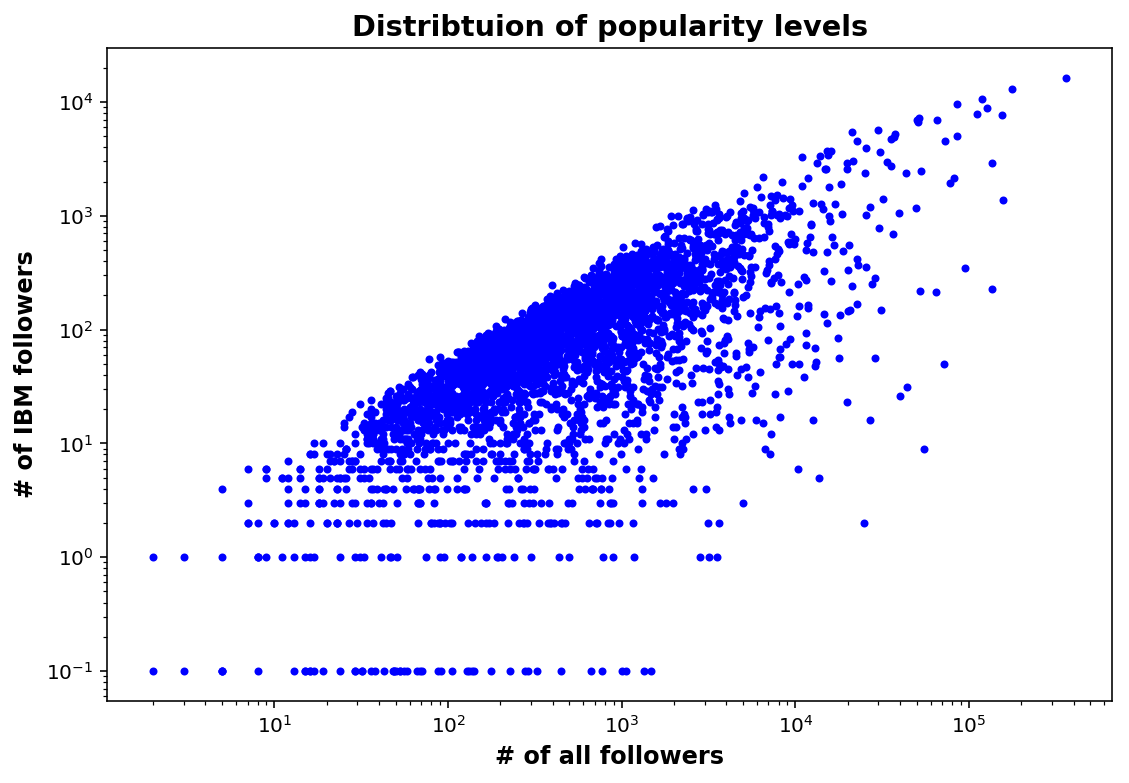

In [14]:
"""
Lineplot of total/IBM/non-IBM followers
"""
m1_ibm_popularity_levels_2_fig = os.path.join(FIG_DIR, 'm1_ibm_popularity_levels_2.png')
if 1 == 1:
    '''
    Prepare data
    '''
    followers_all = df['fo_2']
    followers_ibm = df['fo_ibm']
    
    #followers_all_rank = df['fo_2'].rank(method='average', ascending=False)
  
    '''
    Plot
    '''
    fig, ax = plt.subplots(figsize=(9, 6))
    
#     lp = plt.plot(followers_all_rank, followers_all, 'g.', followers_all_rank, followers_ibm, 'b.')
    lp = plt.plot(followers_all, followers_ibm, 'b.')
    
    title_fontdict = {'weight': 'bold', 'size': 'x-large'}
    ax.set_title("Distribtuion of popularity levels", fontdict=title_fontdict)
    
    label_fontdict = {'weight': 'bold', 'size': 'large'}
    ax.set_xlabel('# of all followers', fontdict=label_fontdict)
    ax.set_ylabel('# of IBM followers', fontdict=label_fontdict)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    '''
    Save figure
    '''
    plt.savefig(m1_ibm_popularity_levels_2_fig, dpi=200)

In [15]:
"""
Check Pearson Correlation between all/IBM popularity levels
"""
df[['fo_2', 'fo_ibm', 'fo_nonibm']].corr()

,fo_2,fo_ibm,fo_nonibm
fo_2,1.000000,0.777249,0.999173
fo_ibm,0.777249,1.000000,0.751029
fo_nonibm,0.999173,0.751029,1.000000


In [16]:
np.corrcoef(np.log(df['fo_2']), np.log(df['fo_ibm']))

array([[ 1.        ,  0.67488236],
       [ 0.67488236,  1.        ]])

In [17]:
from scipy.stats.stats import pearsonr   

pearsonr(np.log(df['fo_2']), np.log(df['fo_ibm']))

(0.67488235697404908, 0.0)

In [18]:
df_tmp = pd.DataFrame({'log_fo': np.log(df['fo_2']), 'log_fo_ibm': np.log(df['fo_ibm']), 'log_fo_nonibm': np.log(df['fo_nonibm'])})
df_tmp.corr()

,log_fo,log_fo_ibm,log_fo_nonibm
log_fo,1.000000,0.674882,0.993896
log_fo_ibm,0.674882,1.000000,0.611627
log_fo_nonibm,0.993896,0.611627,1.000000


## Check the distribution of followers_engagement levels of M1 IBM users
The follwers engagement level of a user is calculated as the average retweet_count over all native tweets

In [21]:
df_out.describe()

,uid,fo,all_n,all_srt,ibm_n,ibm_srt,nonibm_n,nonibm_srt,fo_2,fo_ibm,native_n,fo_nonibm,out_simple_inf,out_compound_inf
count,3.174000e+03,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3.174000e+03,3174.000000
mean,5.426757e+16,2347.766541,8.539698,41.583806,4.316005,12.728418,7.044423,28.855388,2364.980466,209.311279,22.462823,2155.669187,8.691144e-03,7.633369
std,1.983035e+17,11157.252926,26.456253,388.215307,18.500603,124.058004,23.694071,271.157832,11218.891164,689.851665,60.838627,10691.471972,5.044709e-02,28.603868
min,1.142600e+04,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,7.014890e-07,0.000000
25%,5.679811e+07,165.250000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,174.000000,25.000000,3.000000,131.000000,3.885894e-04,1.407523
50%,3.696389e+08,438.000000,2.000000,4.000000,1.000000,1.000000,2.000000,3.000000,451.000000,70.000000,6.000000,348.500000,1.401542e-03,3.131245
75%,2.242133e+09,1283.750000,6.000000,13.000000,3.000000,4.000000,4.000000,8.000000,1314.750000,172.000000,20.000000,1107.000000,4.629630e-03,6.555044
max,8.623589e+17,360556.000000,428.000000,14497.000000,333.000000,4877.000000,426.000000,9620.000000,362337.000000,16223.000000,1330.000000,346114.000000,2.000000e+00,795.789550


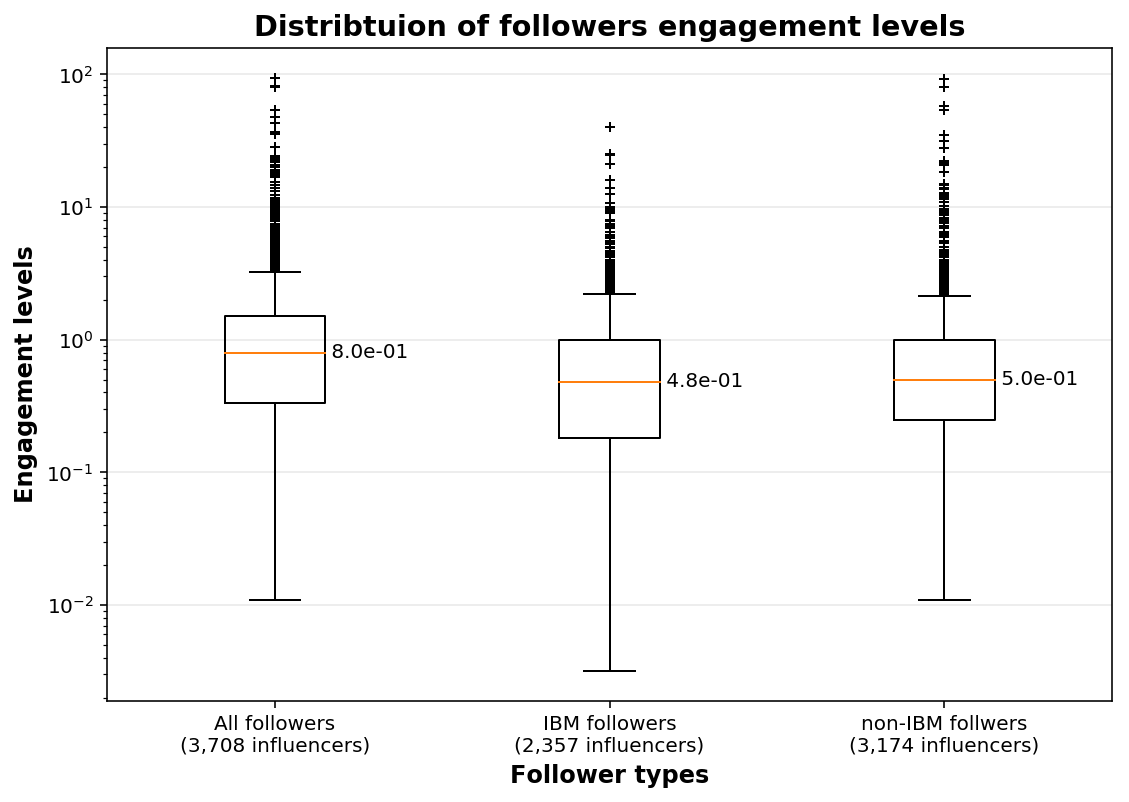

In [22]:
"""
Boxplot of average retweet_count by all/IBM/non-IBM followers
"""
m1_ibm_followers_engagement_levels_fig = os.path.join(FIG_DIR, 'm1_ibm_followers_engagement_levels.png')
if 1 == 1:
    '''
    Prepare data
    '''
    avg_rt_all = df['all_srt'] / df['native_n']
    avg_rt_ibm = df_in['ibm_srt'] / df_in['native_n']
    avg_rt_nonibm = df_out['nonibm_srt'] / df_out['native_n']
            
    data = [avg_rt_all, avg_rt_ibm, avg_rt_nonibm]
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(figsize=(9, 6))
    
    bp = plt.boxplot(data, notch=False, sym='k+', vert=True)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+', markersize=5)
    
    title_fontdict = {'weight': 'bold', 'size': 'x-large'}
    ax.set_title("Distribtuion of followers engagement levels", fontdict=title_fontdict)
    
    label_fontdict = {'weight': 'bold', 'size': 'large'}
    ax.set_xlabel('Follower types', fontdict=label_fontdict)
    ax.set_ylabel('Engagement levels', fontdict=label_fontdict)
    ax.set_xticklabels(['All followers\n({:,} influencers)'.format(avg_rt_all.shape[0]),
                        'IBM followers\n({:,} influencers)'.format(avg_rt_ibm.shape[0]),
                        'non-IBM follwers\n({:,} influencers)'.format(avg_rt_nonibm.shape[0])])
    ax.set_yscale('log')
    
    # add a horizontal grid to the plot, but make it very light in color
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)
    
    # add median value text to the median line
    for line in bp['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # right point of median line
        # overlay median value
        ax.text(x, y, '{:8.1e}'.format(y), horizontalalignment='left', verticalalignment='center')
    
    '''
    Save figure
    '''
    plt.savefig(m1_ibm_followers_engagement_levels_fig, dpi=200)

## Simple influence by different (user_popularity, followers_engagement) combinations

## Compound inlfuence by different (user_popularity, followers_engagement) combinations